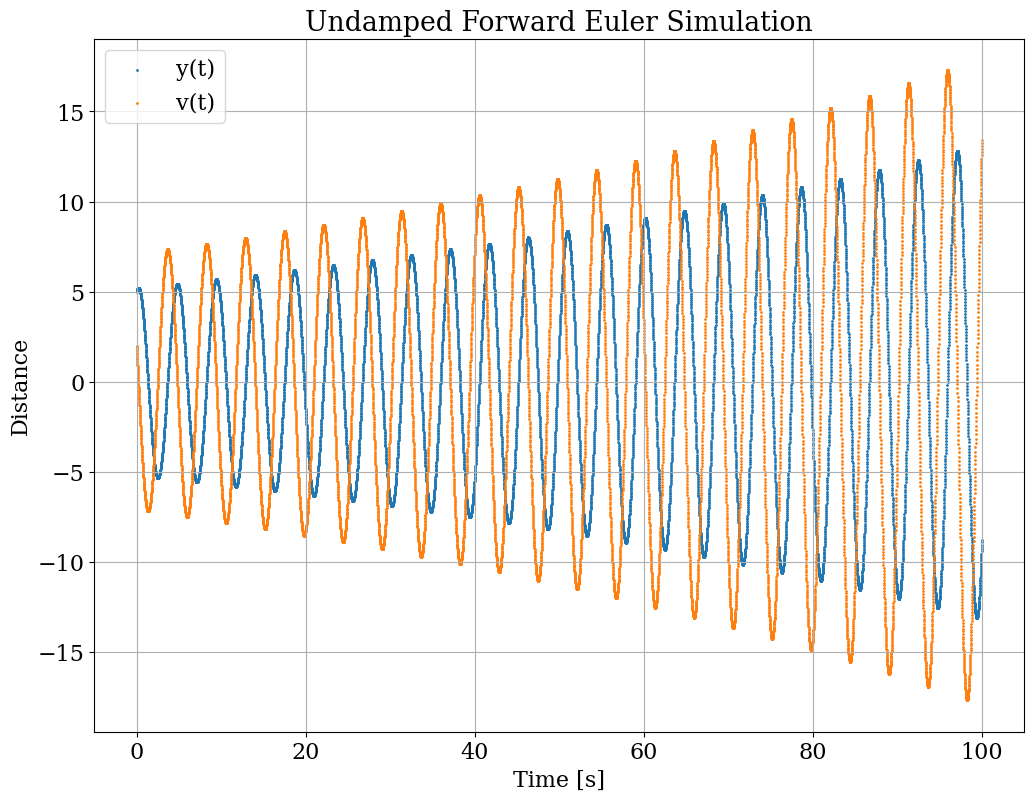

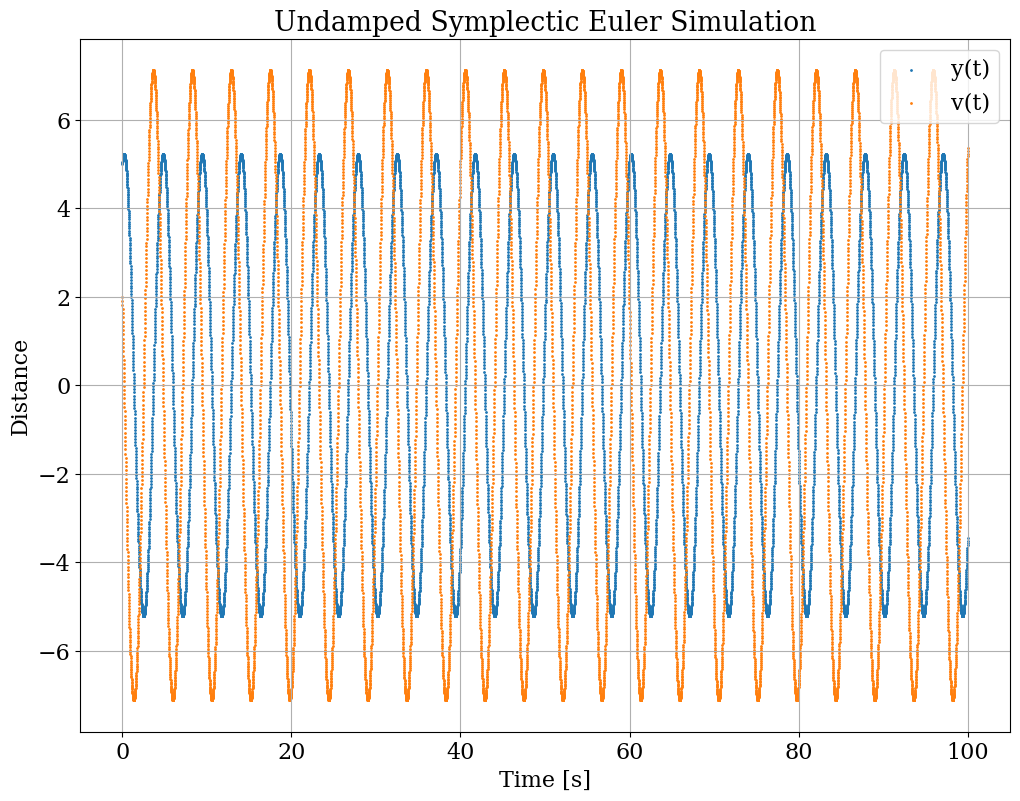

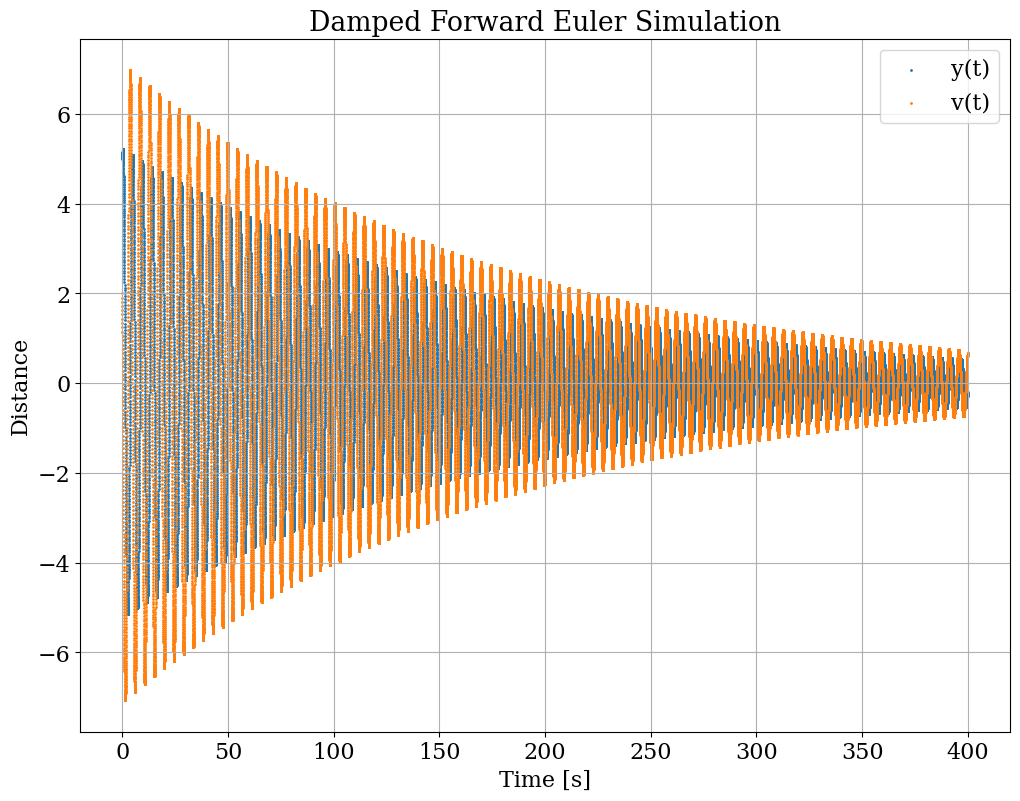

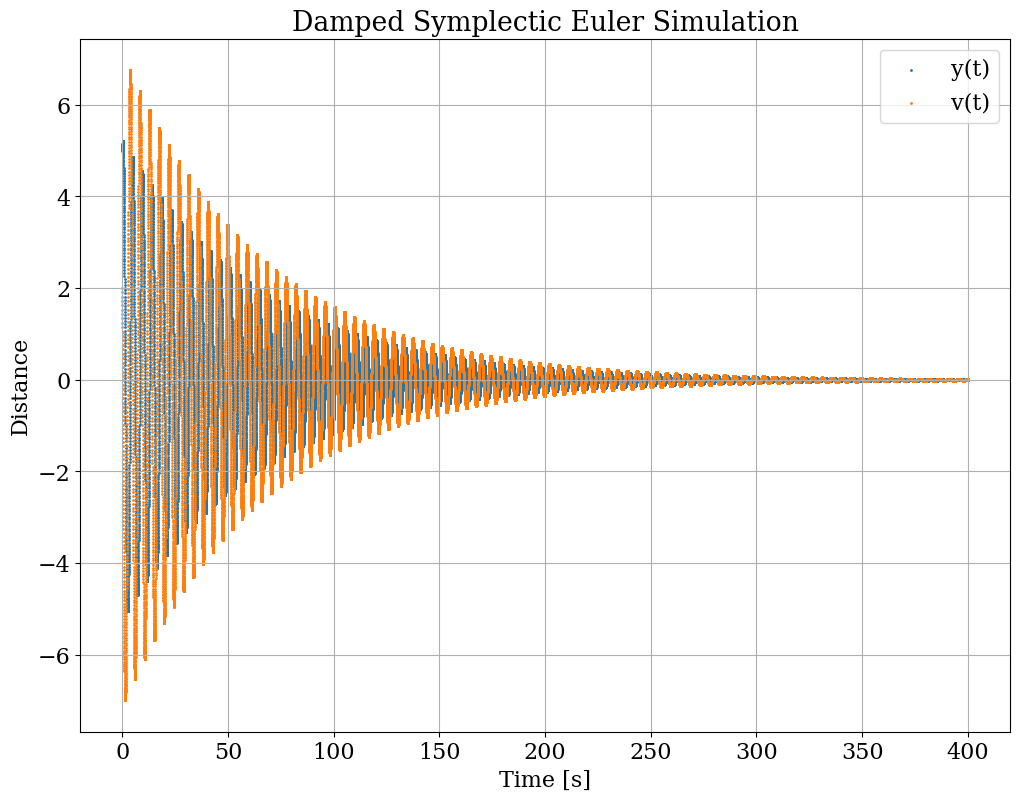

In [32]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'figure.figsize': (12, 9), 'font.family': 'serif'})

dt = 1/100
m1 = 0.2003 # w/o disk
m2 = 0.2171 # w/ disk
omega_0 = 1/.734
gamma = 0.03

def forward_euler(y_0, v_0, omega_0, dt, t_max):
    t = np.linspace(0,t_max, int(t_max/dt))
    y = np.zeros(len(t))
    v = np.zeros(len(t))  
    y[0] = y_0
    v[0] = v_0
    for i in range(1,len(t)):
        y[i] = y[i-1] + dt*v[i-1]
        v[i] = v[i-1] - dt*omega_0**2*y[i-1]
    return y, v, t

def symplectic_euler(y_0, v_0, omega_0, dt, t_max):
    t = np.linspace(0,t_max, int(t_max/dt))
    y = np.zeros(len(t))
    v = np.zeros(len(t))  
    y[0] = y_0
    v[0] = v_0
    for i in range(1,len(t)):
        y[i] = y[i-1] + dt*v[i-1]
        v[i] = v[i-1] - dt*omega_0**2*y[i]
    return y, v, t

def forward_euler_damped(y_0, v_0, omega_0, dt, t_max):
    t = np.linspace(0,t_max, int(t_max/dt))
    y = np.zeros(len(t))
    v = np.zeros(len(t))  
    y[0] = y_0
    v[0] = v_0
    for i in range(1,len(t)):
        y[i] = y[i-1] + dt*v[i-1]
        v[i] = v[i-1] - (omega_0**2*y[i-1] + gamma*v[i-1])*dt
    return y, v, t

def symplectic_euler_damped(y_0, v_0, omega_0, dt, t_max):
    t = np.linspace(0,t_max, int(t_max/dt))
    y = np.zeros(len(t))
    v = np.zeros(len(t))  
    y[0] = y_0
    v[0] = v_0
    for i in range(1,len(t)):
        y[i] = y[i-1] + dt*v[i-1]
        v[i] = v[i-1] - dt*(omega_0**2*y[i] + gamma*v[i-1])
    return y, v, t

y, v, t = forward_euler(5, 2, omega_0, dt, 100)
plt.title("Undamped Forward Euler Simulation")
plt.scatter(t,y, label="y(t)",s=1)
plt.scatter(t,v, label="v(t)",s=1)
plt.xlabel("Time [s]")
plt.ylabel("Distance")
plt.legend()
plt.grid()
plt.show()

y_sym, v_sym, t_sym = symplectic_euler(5, 2, omega_0, dt, 100)
plt.title("Undamped Symplectic Euler Simulation")
plt.scatter(t_sym,y_sym, label="y(t)",s=1)
plt.scatter(t_sym,v_sym, label="v(t)",s=1)
plt.xlabel("Time [s]")
plt.ylabel("Distance")
plt.legend()
plt.grid()
plt.show()


y, v, t = forward_euler_damped(5, 2, omega_0, dt, 400)
plt.title("Damped Forward Euler Simulation")
plt.scatter(t,y, label="y(t)", s=1)
plt.scatter(t,v, label="v(t)", s=1)
plt.xlabel("Time [s]")
plt.ylabel("Distance")
plt.legend()
plt.grid()
plt.show()

y_sym, v_sym, t_sym = symplectic_euler_damped(5, 2, omega_0, dt, 400)
plt.title("Damped Symplectic Euler Simulation")
plt.scatter(t_sym,y_sym, label="y(t)", s=1)
plt.scatter(t_sym,v_sym, label="v(t)", s=1)
plt.xlabel("Time [s]")
plt.ylabel("Distance")
plt.legend()
plt.grid()
plt.show()

